Use the Harris method to detect the corners of the squares that compose the figure of a chess board. From those squares determine:
- How many different squares compose the figure
- The average size of each of the squares.

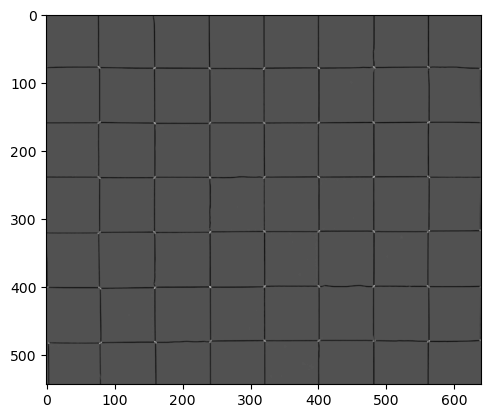

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('./chessBoard.png')

# plot
plt.imshow(img)

# compute corners using Harris corner detector
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)

dst = cv2.cornerHarris(gray, 2, 3, 0.04)

# plot
plt.imshow(dst, cmap='gray')




Now that we have the points computed using the OpenCV library we will implement our own Harris corner detector. We will use the same image as before. In order to implement our Harris function we will:

- Compute the derivatives of the image in the x and y directions
- Compute the products of the derivatives
- Compute the sums of the products of the derivatives
- Compute the Harris response function
- Threshold the response function to detect the corners

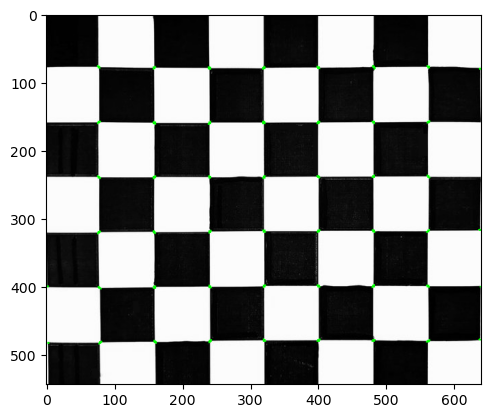

In [65]:
# hand-crafted harris corner detector
def harris_corner_detector(img, k=0.04, window_size=3, threshold=0.01):
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)

    # remove noise using Gaussian filter
    gray = cv2.GaussianBlur(gray, (window_size, window_size), 0)
    
    # compute derivatives (using Sobel operator)
    Ix = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=window_size)
    Iy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=window_size)
    
    # compute products of derivatives at every pixel
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy
    
    # compute sums of products of derivatives using Gaussian filter
    Sxx = cv2.GaussianBlur(Ixx, (window_size, window_size), 0)
    Syy = cv2.GaussianBlur(Iyy, (window_size, window_size), 0)
    Sxy = cv2.GaussianBlur(Ixy, (window_size, window_size), 0)
    
    # compute the determinant and trace of the matrix
    det = (Sxx * Syy) - (Sxy * Sxy)
    trace = Sxx + Syy
    
    # compute the corner strentgh function
    R = det - k * (trace ** 2)
    
    # threshold the response
    R[R < threshold * R.max()] = 0
    
    return R

# duplicate the image in order to overlay the corners
img = cv2.imread('./chessBoard.png')
corners = img.copy()

# compute corners using Harris corner detector
dst = harris_corner_detector(img, k=0.01, threshold=.1)

# overlay corners on the image
corners[dst > 0.01 * dst.max()] = [0, 255, 0]

# plot
plt.imshow(corners, cmap='gray')

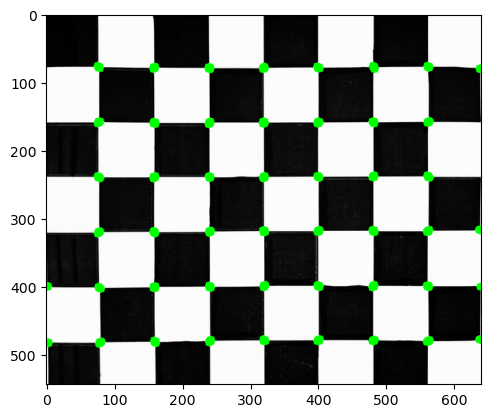

In [67]:
# Draw circles on the corners
img = cv2.imread('./chessBoard.png')
dst = harris_corner_detector(img, k=0.01, threshold=.1)

# find the coordinates of the corners
coords = np.where(dst > 0.01 * dst.max())

# draw circles on the corners
for i in range(len(coords[0])):
    cv2.circle(img, (coords[1][i], coords[0][i]), 5, (0, 255, 0), -1)

# plot
plt.imshow(img, cmap='gray')

We can see that the corners detected by our function are very similar to the ones detected by the OpenCV function. The only difference is that our function detects more corners. Specially on the side of the screen, however more images would be needed to corroborate this.

49


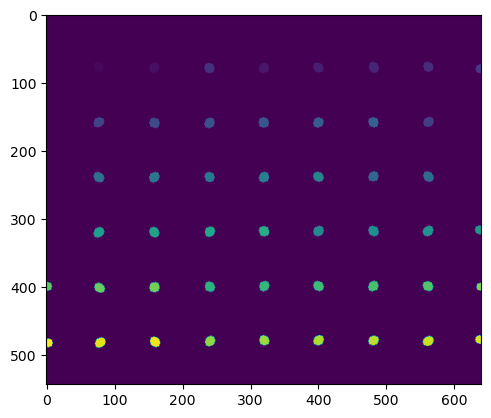

In [100]:
# Count the number of circles in img.
# We could employ connected components algorithm in order to count the number of circles.

# Draw circles on the corners
img = cv2.imread('./chessBoard.png')
dst = harris_corner_detector(img, k=0.01, threshold=.1)

# find the coordinates of the corners
coords = np.where(dst > 0.01 * dst.max())

# draw circles on the corners
for i in range(len(coords[0])):
    cv2.circle(dst, (coords[1][i], coords[0][i]), 5, (255, 255, 255), -1)

# plot
plt.imshow(dst)

# compute the number of corners using connected components algorithm
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst.astype(np.uint8))

# plot
print(len(centroids))
plt.imshow(labels)

One problem that we have is that in the edges of the image we sometimes get false positives. This is because the derivatives are not well defined in the edges of the image. We can solve this problem by using a bigger Gaussian filter to smooth the image before computing the derivatives.

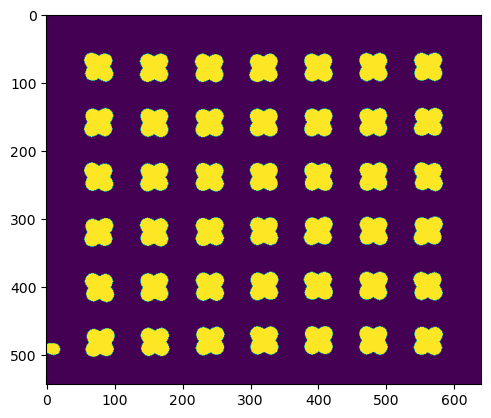

In [116]:
# Draw circles on the corners
img = cv2.imread('./chessBoard.png')

# Apply Gaussian filter to remove false positives on edges
img = cv2.GaussianBlur(img, (47, 47), 0)
# Apply corner detection with a bigger window size
dst = harris_corner_detector(img, k=0.01, window_size=15, threshold=.1)

# find the coordinates of the corners
coords = np.where(dst > 0.01 * dst.max())

# draw circles on the corners
for i in range(len(coords[0])):
    cv2.circle(dst, (coords[1][i], coords[0][i]), 5, (255, 255, 255), -1)

# plot
plt.imshow(dst)

As shown, even with a big window size we still detect corners on the edges of the image. Upon further observation we found that this is happening due to the chess board image being slightly rotated. This causes the corners to be detected on the edges of the image. We can solve this problem by rotating the image so that the chess board is perfectly horizontal, but as we dont know the angle of rotation we will add a small grey border.

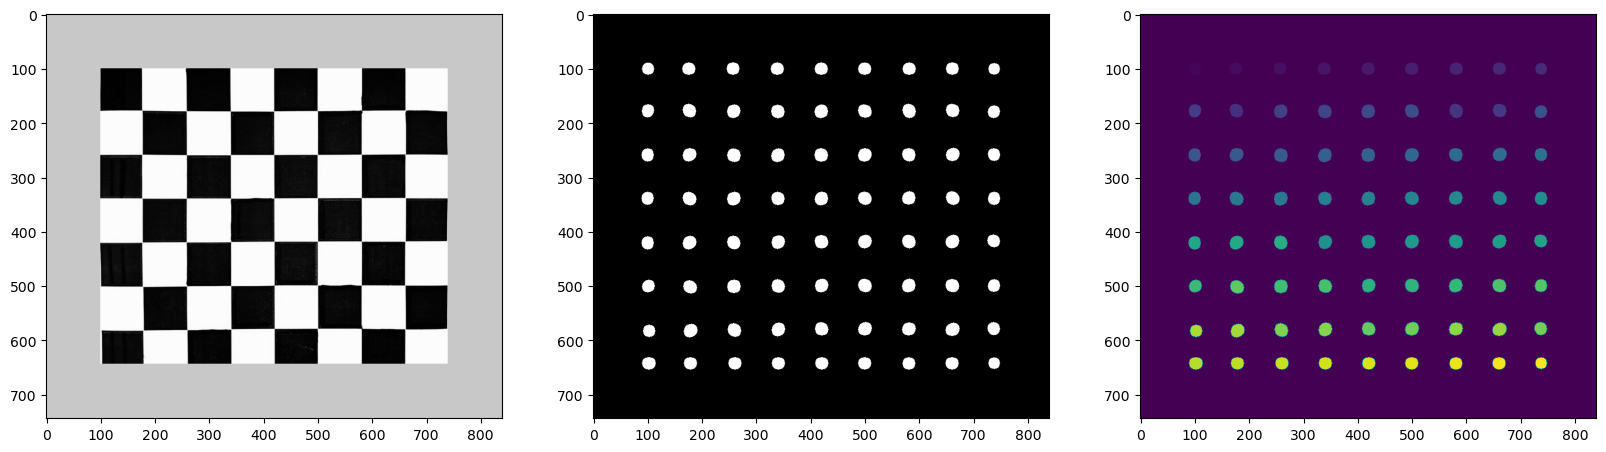

In [244]:
# Draw circles on the corners


# Add small border to the image
img = cv2.imread('./chessBoard.png')
px = 100
img = cv2.copyMakeBorder(img, 100, 100, 100, 100, cv2.BORDER_CONSTANT, value=[px, px, px])
dst = harris_corner_detector(img, k=0.01, threshold=.1)
coords_100 = np.where(dst > 0)

img = cv2.imread('./chessBoard.png')
px = 200
img = cv2.copyMakeBorder(img, 100, 100, 100, 100, cv2.BORDER_CONSTANT, value=[px, px, px])
dst = harris_corner_detector(img, k=0.01, threshold=.1)
coords_200 = np.where(dst > 0)

# draw circles on the corners
for i in range(len(coords_100[0])):
    cv2.circle(dst, (coords_100[1][i], coords_100[0][i]), 10, (255, 255, 255), -1)

# draw circles on the corners and coordinates of the corners
for i in range(len(coords_200[0])):
    cv2.circle(dst, (coords_200[1][i], coords_200[0][i]), 10, (255, 255, 255), -1)

# compute the number of corners using connected components algorithm
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst.astype(np.uint8))

# plot all images
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(dst, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(labels)

Now we have a separated region for each of our detected corners. We will just have to count them in order to get the number of squares in the chess board. We will consider that whenever a centroid x value is less than the previous centroid x value, we have a new row of corners. To compute the number of corners in the y axis, we divide the total number of centroids by the number of corners in the x axis.

In [256]:
print("Number of detected edges + background = ",len(centroids))
print("Number of detected edges = ",len(centroids)-1)

# truncate all centroids to integer
c = centroids.astype(int)[1:]
# sort the centroids by y axis
c = c[c[:,1].argsort()]

# compute the number of corners in the x axis by parsing the centroids. 
num_corners_x = 1
for i in range(1, len(c)):
    if c[i][0] > c[i-1][0]:
        num_corners_x += 1
    else:
        break
num_corners_y = len(c) // num_corners_x
print("Corners X:",num_corners_x, "Corners Y:",num_corners_y)

# To compute the number of squares
num_squares_x = num_corners_x - 1
num_squares_y = num_corners_y - 1
print("Number of squares:", (num_squares_x)*(num_squares_y))

Number of detected edges + background =  73
Number of detected edges =  72
Corners X: 9 Corners Y: 8
Number of squares: 56


We can compute the "dimensions" of squares by computing the average distance between the corners. We will do this by computing the average distance between the corners in the x and y directions.

In [275]:
corners_reshaped = c.reshape(num_corners_y, num_corners_x, 2)

# To compute the size of a square we will use the pre-computed numbers of squares and corners
cr = corners_reshaped
cr=np.sort(cr, axis=1)

top_left_corner  = cr[0,0]
top_right_corner = cr[0,1]
bottom_left_corner = cr[1,0]
bottom_right_corner = cr[1,1]

#print(top_left_corner, top_right_corner, bottom_left_corner, bottom_right_corner)

# compute the size of a square
square_size = np.sqrt((top_left_corner[0] - top_right_corner[0])**2 + (top_left_corner[1] - top_right_corner[1])**2)
print("Square size:", square_size)

Square size: 75.0


Now we will compute the average size of the squares.

In [282]:
avg_x_size = 0
avg_y_size = 0

# Compute the average size of a square
for i in range(0, num_corners_x-1):
    for j in range(0, num_corners_y-1):
        tlc = cr[j,   i  ]
        trc = cr[j,   i+1]
        blc = cr[j+1, i  ]
        brc = cr[j+1, i+1]

        avg_x_size += (trc[0]-tlc[0])
        avg_y_size += (blc[1]-tlc[1])

avg_x_size = avg_x_size / (num_squares_x * num_squares_y)
avg_y_size = avg_y_size / (num_squares_x * num_squares_y)
print("Average square size: x:", avg_x_size,"y:",avg_y_size)

Average square size: x: 79.625 y: 77.42857142857143
